In [2]:
# %pip install tensorflow==2.1
# %pip install keras-tcn

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPool1D, LSTM, Input, GRU
from tensorflow.keras import backend as K
from tcn import TCN
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import mean_absolute_error
import datetime
import random
import math

In [3]:
np.random.seed(1)
tf.random.set_seed(1)
random.seed(1)

In [7]:
import pandas as pd

In [8]:
df3 = pd.read_csv('chb01_3c.csv')
df4 = pd.read_csv('chb01_4c.csv')
df15 = pd.read_csv('chb01_15c.csv')
df16 = pd.read_csv('chb01_16c.csv')
df18 = pd.read_csv('chb01_18c.csv')
df21 = pd.read_csv('chb01_21c.csv')
df26 = pd.read_csv('chb01_26c.csv')

In [9]:
df3 = df3.drop(labels='Unnamed: 0',axis=1)
df4 = df4.drop(labels='Unnamed: 0',axis=1)
df15 = df15.drop(labels='Unnamed: 0',axis=1)
df16 = df16.drop(labels='Unnamed: 0',axis=1)
df18 = df18.drop(labels='Unnamed: 0',axis=1)
df21 = df21.drop(labels='Unnamed: 0',axis=1)
df26 = df26.drop(labels='Unnamed: 0',axis=1)

In [10]:
from sklearn.preprocessing import MinMaxScaler

In [12]:
scaler = MinMaxScaler(feature_range=(0,1))
df3 = scaler.fit_transform(df3)
df4 = scaler.fit_transform(df4)
df15 = scaler.fit_transform(df15)
df16 = scaler.fit_transform(df16)
df18 = scaler.fit_transform(df18)
df21 = scaler.fit_transform(df21)
df26 = scaler.fit_transform(df26)

In [14]:
# plt.plot(df3)

In [15]:
print((df3.shape),(df4.shape),(df15.shape),(df16.shape),(df18.shape),(df21.shape),(df26.shape))

(20481, 23) (13825, 23) (20481, 23) (26113, 23) (46081, 23) (47617, 23) (51713, 23)


In [16]:
past_history = 1279
forecast_horizon = 255

In [17]:
df3 = pd.DataFrame(df3).to_numpy()
df4 = pd.DataFrame(df4).to_numpy()
df15 = pd.DataFrame(df15).to_numpy()
df16 = pd.DataFrame(df16).to_numpy()
df18 = pd.DataFrame(df18).to_numpy()
df21 = pd.DataFrame(df21).to_numpy()
df26 = pd.DataFrame(df26).to_numpy()

In [18]:
def vectorized_stride(array, clearing_time_index, max_time, sub_window_size,
                         stride_size):
    start = clearing_time_index + 1 - sub_window_size + 1
    
    sub_windows = (
        start + 
        np.expand_dims(np.arange(sub_window_size), 0) +
        # Create a rightmost vector as [0, V, 2V, ...].
        np.expand_dims(np.arange(max_time + 1, step=stride_size), 0).T
    )
    
    return array[sub_windows]

In [19]:
r3 = len(df3)-(len(df3)%1279)-1
r4 = len(df4)-(len(df4)%1279)-1
r15 = len(df15)-(len(df15)%1279)-1
r16 = len(df16)-(len(df16)%1279)-1
r18 = len(df18)-(len(df18)%1279)-1
r21 = len(df21)-(len(df21)%1279)-1
r26 = len(df26)-(len(df26)%1279)-1

In [21]:
df3_w = vectorized_stride(df3,1279,r3,1279,1279)
df4_w = vectorized_stride(df4,1279,r4,1279,1279)
df15_w = vectorized_stride(df15,1279,r15,1279,1279)
df16_w = vectorized_stride(df16,1279,r16,1279,1279)
df18_w = vectorized_stride(df18,1279,r18,1279,1279)
df21_w = vectorized_stride(df21,1279,47617-295,1279,1279)
df26_w = vectorized_stride(df26,1279,r26,1279,1279)

In [22]:
print(df3_w.shape,df4_w.shape, df16_w.shape, df15_w.shape, df18_w.shape, df21_w.shape, df26_w.shape)

(16, 1279, 23) (10, 1279, 23) (20, 1279, 23) (16, 1279, 23) (36, 1279, 23) (37, 1279, 23) (40, 1279, 23)


In [23]:
df3 = np.array(df3_w)
df4 = np.array(df4_w)
df15 = np.array(df15_w)
df16 = np.array(df16_w)
df18 = np.array(df18_w)
df21 = np.array(df21_w)
df26 = np.array(df26_w)

In [24]:
Train = np.vstack((df3 ,df4,df15 ,df16 ,df18 ,df21 ))
Test = (df26)

In [25]:
Train.shape

(135, 1279, 23)

In [26]:
Test.shape

(40, 1279, 23)

In [28]:
L3nsz = np.zeros((8,1))
L3sz = np.ones((8,1))
L3 = np.append(L3nsz,L3sz)

L4nsz = np.zeros((5,1))
L4sz = np.ones((5,1))
L4 = np.append(L4nsz,L4sz)

L15nsz = np.zeros((8,1))
L15sz = np.ones((8,1))
L15 = np.append(L15nsz,L15sz)

L16nsz = np.zeros((10,1))
L16sz = np.ones((10,1))
L16 = np.append(L16nsz,L16sz)

L18nsz = np.zeros((18,1))
L18sz = np.ones((18,1))
L18 = np.append(L18nsz,L18sz)

L21nsz = np.zeros((18,1))
L21sz = np.ones((19,1))
L21 = np.append(L21nsz,L21sz)

L26nsz = np.zeros((20,1))
L26sz = np.ones((20,1))
L26_test = np.append(L26nsz,L26sz)

In [29]:
Labels_Train = np.concatenate((L3,L4,L15,L16,L18,L21))
Labels_Test = L26_test

In [31]:
Labels_Train.shape

(135,)

In [32]:
Labels_Test.shape

(40,)

In [34]:
from tensorflow.keras import backend
from keras.utils import np_utils

In [35]:
nclases = 2
label_train_c = np_utils.to_categorical(Labels_Train,nclases)
label_test_c = np_utils.to_categorical(Labels_Test,nclases)

In [36]:
label_train_c.shape

(135, 2)

In [37]:
label_test_c.shape

(40, 2)

In [38]:
(x_train, y_train), (x_test, y_test) = ((Train,label_train_c),(Test,label_test_c))

In [39]:
print(x_train.shape)
print(x_test.shape)

(135, 1279, 23)
(40, 1279, 23)


In [52]:
def show_plot(x, y, y_pred=None):
  fig, ax = plt.subplots(1,1, figsize=(15,5))
  ax.plot(x, 'o-', c=colors(3), markersize=3.5, label='History')
  ax.plot([m for m in range(x.shape[0],x.shape[0]+y.shape[0])], y, 'x-', c=colors(0), markersize=3.5, label='True Future')
  if y_pred is not None:
    ax.plot([m for m in range(x.shape[0],x.shape[0]+y.shape[0])], y_pred, 'o-', c=colors(2), markersize=3.5, label='Model prediction')
  ax.legend()

In [49]:
from collections import defaultdict
results = defaultdict(lambda: {})

In [40]:
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, LSTM, Input

In [44]:
# Create model with one LSTM layer with 64 units
inp = Input(shape=x_train.shape[-2:])
x = LSTM(64)(inp)
x = Dense(2)(x)
model = keras.Model(inputs=inp, outputs=x)

In [45]:
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1279, 23)]        0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                22528     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 22,658
Trainable params: 22,658
Non-trainable params: 0
_________________________________________________________________


In [46]:
history = model.fit(x_train, y_train,
          batch_size=256,
          epochs=5,
          verbose=1,
          validation_data=(x_test, y_test))

Epoch 1/5
1/1 [==============================] - 2s 2s/step - loss: 0.5063 - val_loss: 0.5012
Epoch 2/5
1/1 [==============================] - 0s 313ms/step - loss: 0.5035 - val_loss: 0.5009
Epoch 3/5
1/1 [==============================] - 0s 315ms/step - loss: 0.5007 - val_loss: 0.5006
Epoch 4/5
1/1 [==============================] - 0s 341ms/step - loss: 0.4980 - val_loss: 0.5003
Epoch 5/5
1/1 [==============================] - 0s 307ms/step - loss: 0.4952 - val_loss: 0.5000


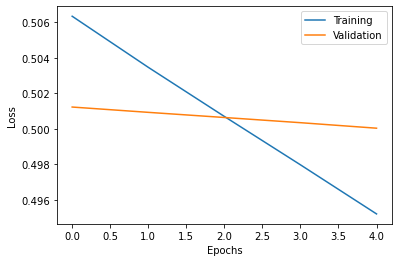

In [47]:
plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.show()

In [50]:
predictions = model.predict(x_test)
mae = mean_absolute_error(y_test, predictions)
results['MAE']['SimpleLSTM'] = mae
results['Y_PRED']['SimpleLSTM'] = predictions
pd.DataFrame(results)['MAE']

SimpleLSTM    0.500037
Name: MAE, dtype: float64

In [54]:
colors = plt.get_cmap('Set3', 23)

C:\Users\Cristian\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


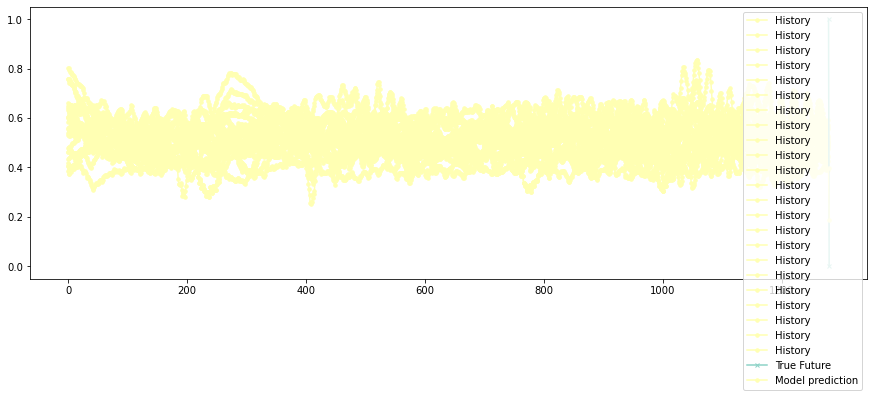

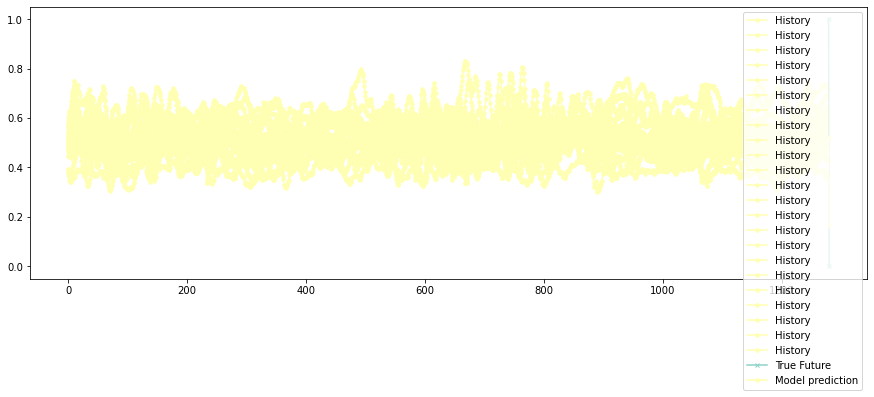

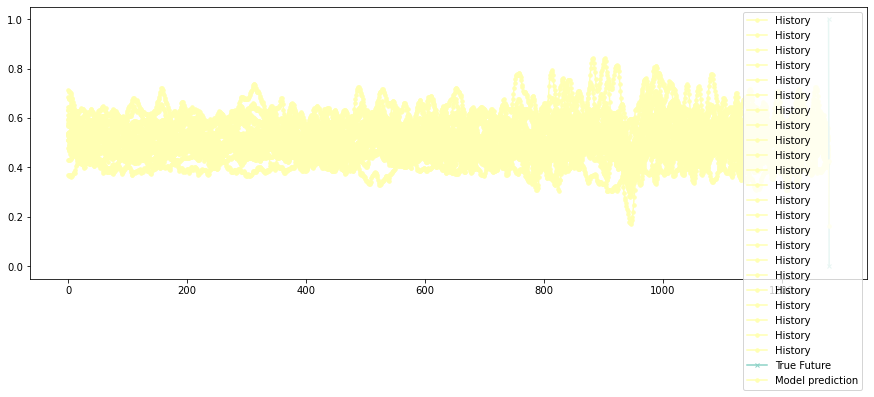

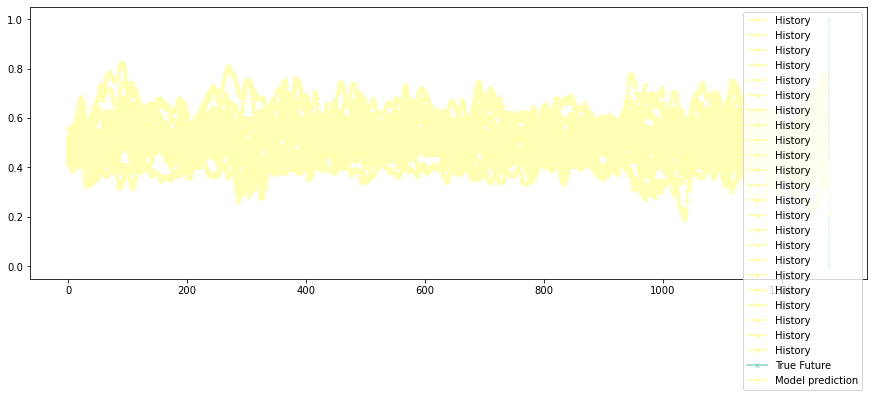

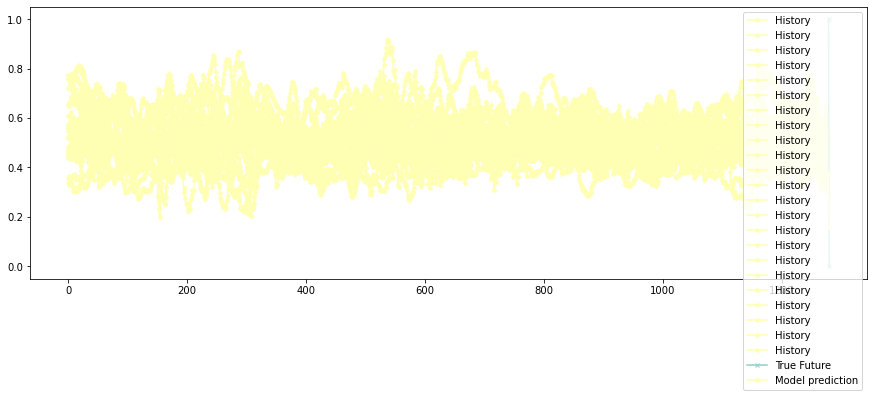

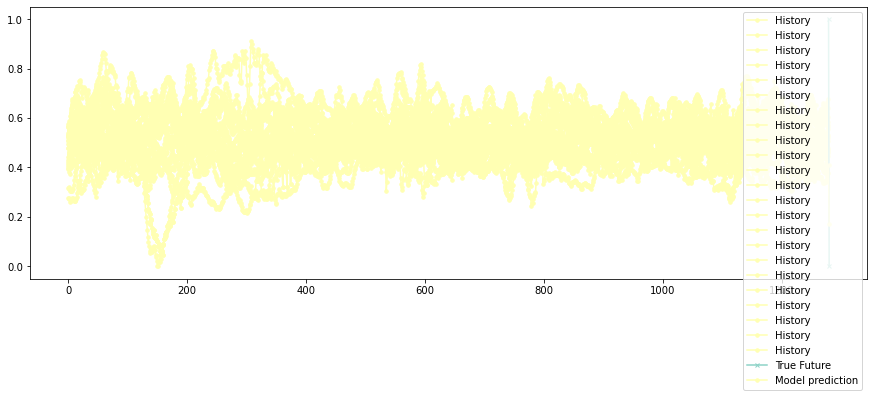

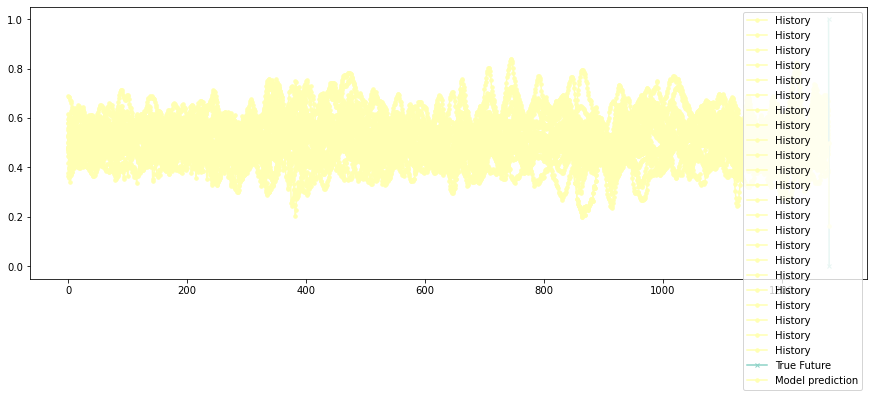

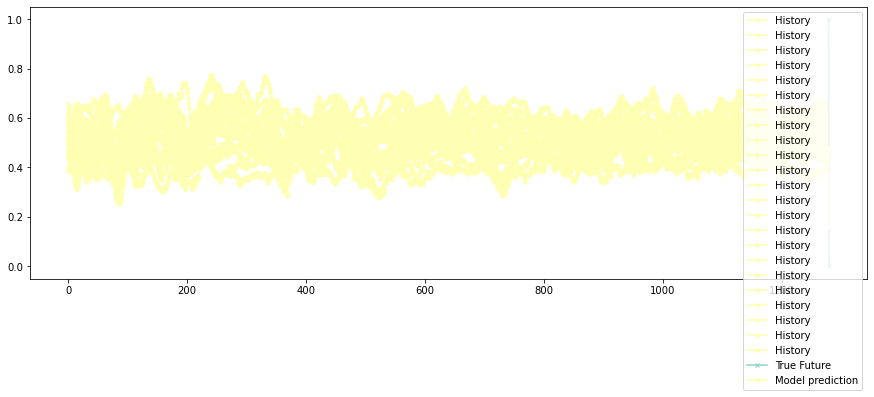

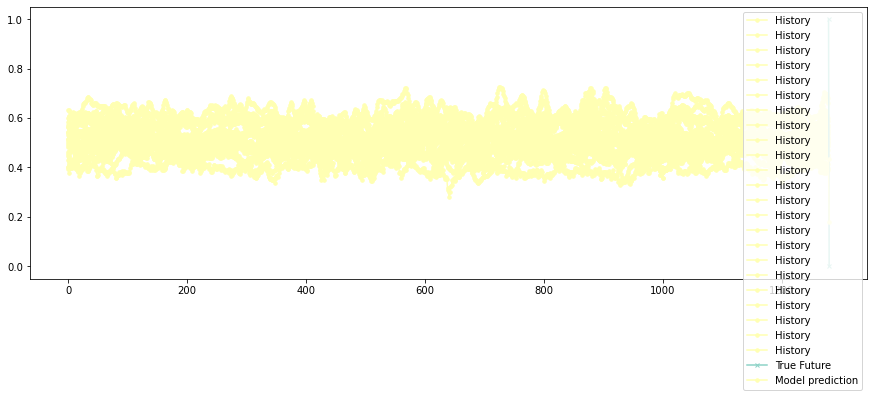

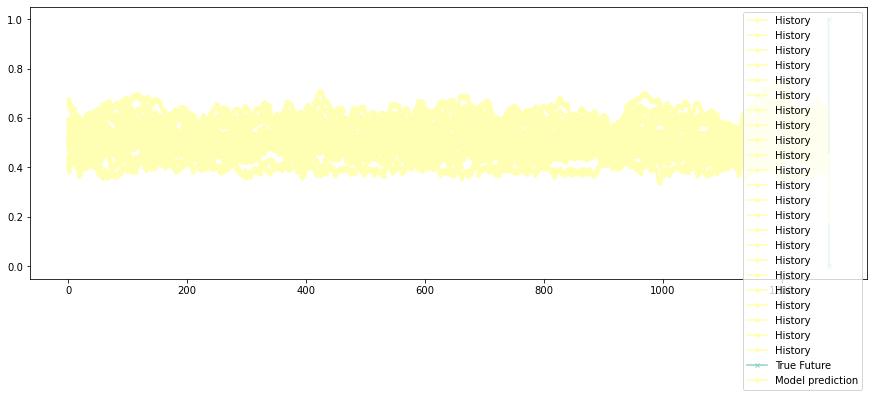

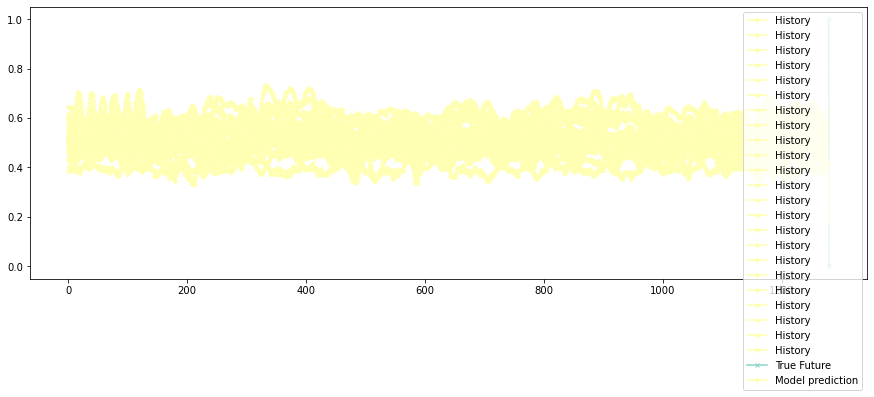

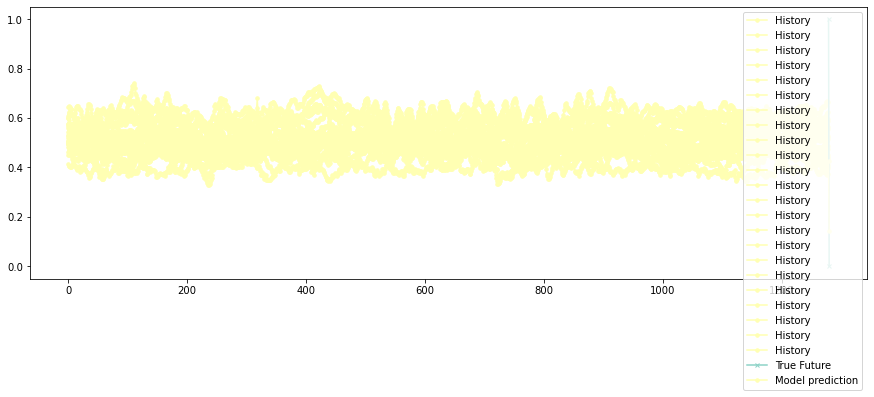

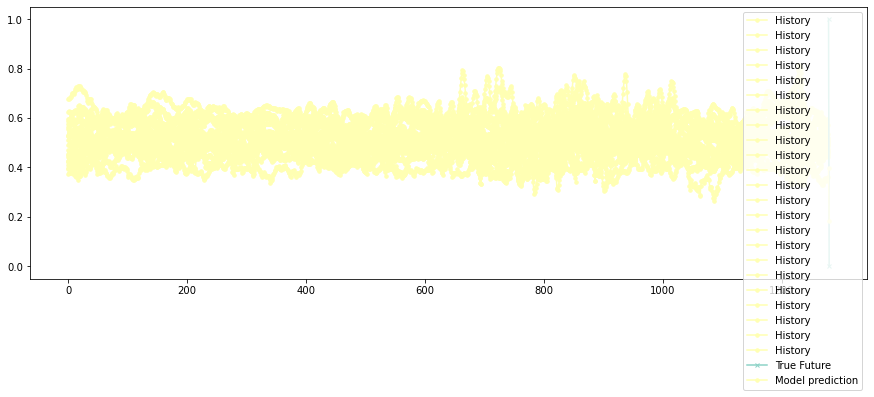

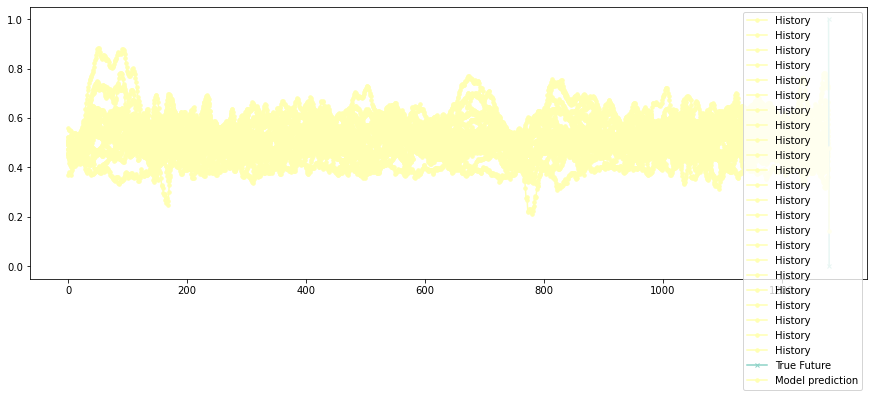

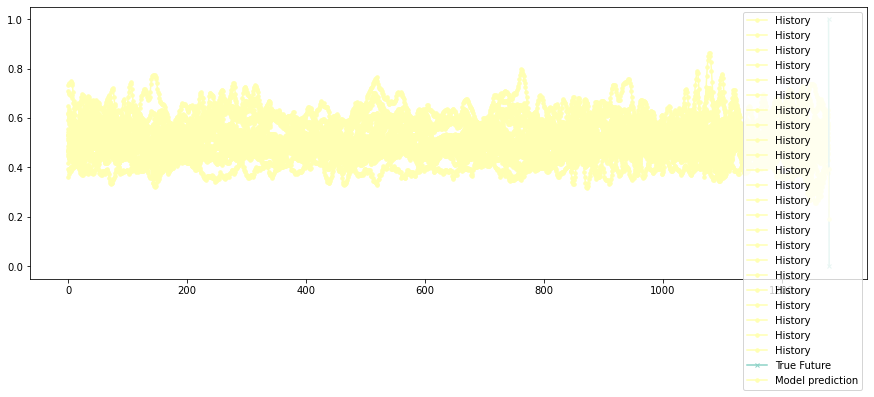

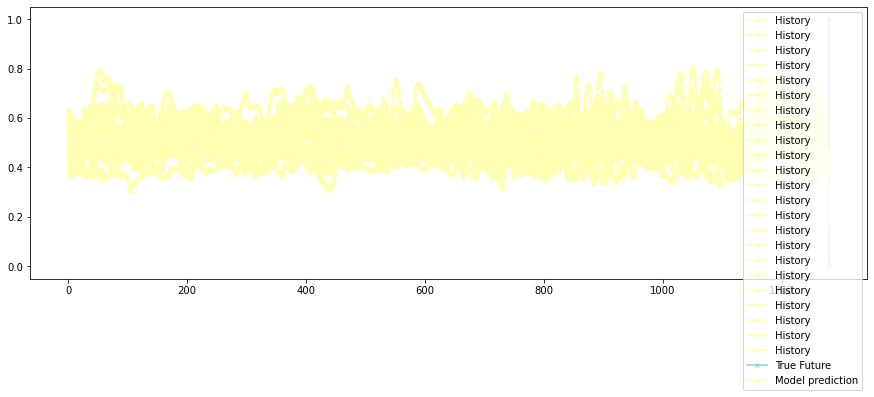

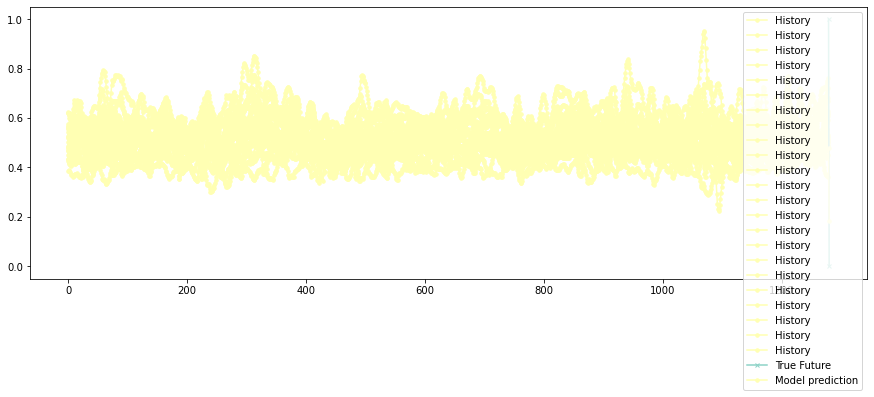

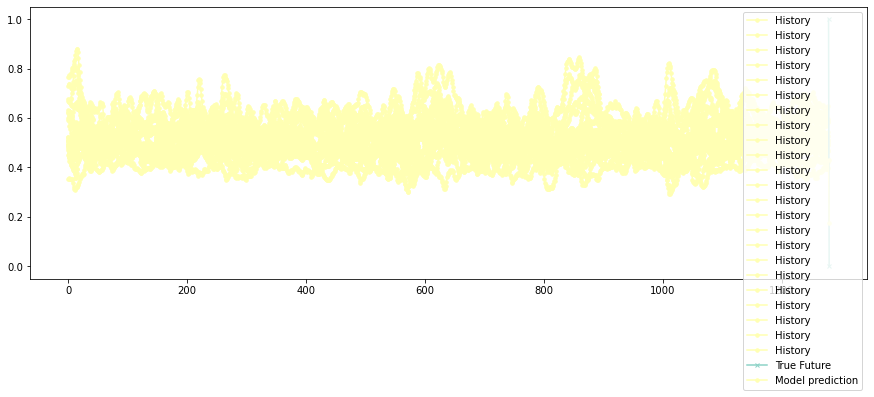

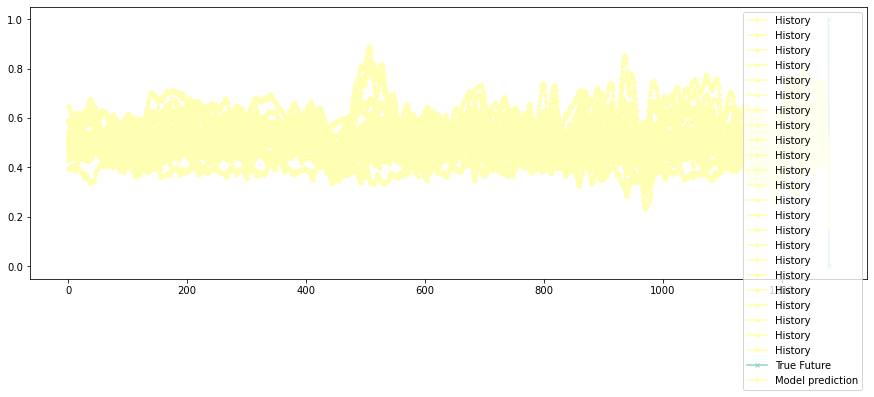

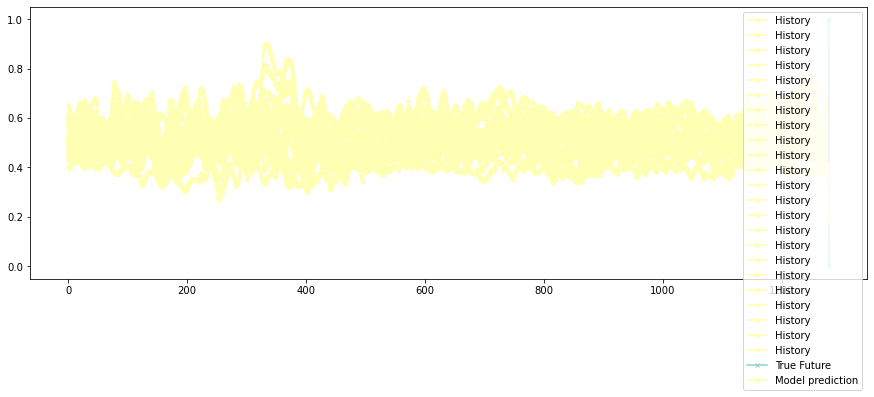

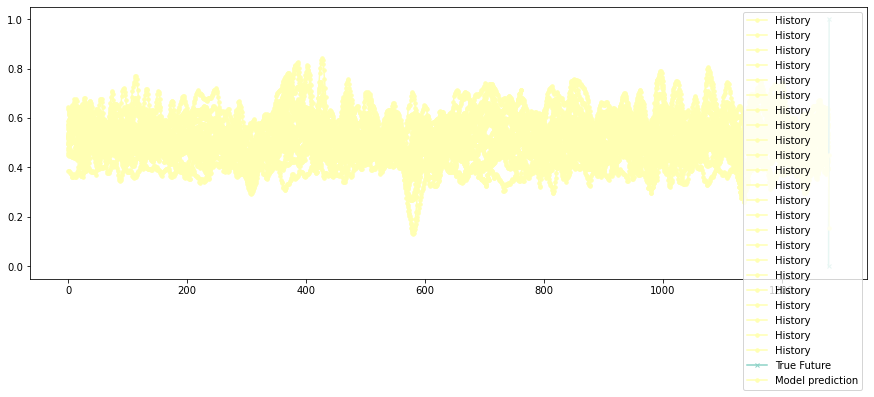

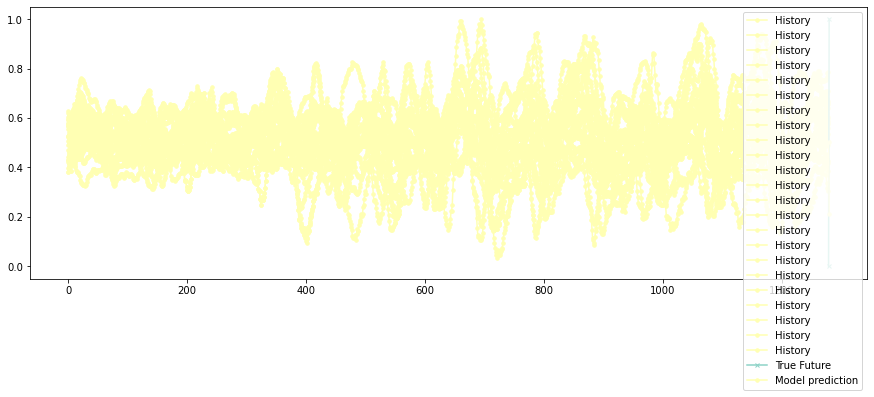

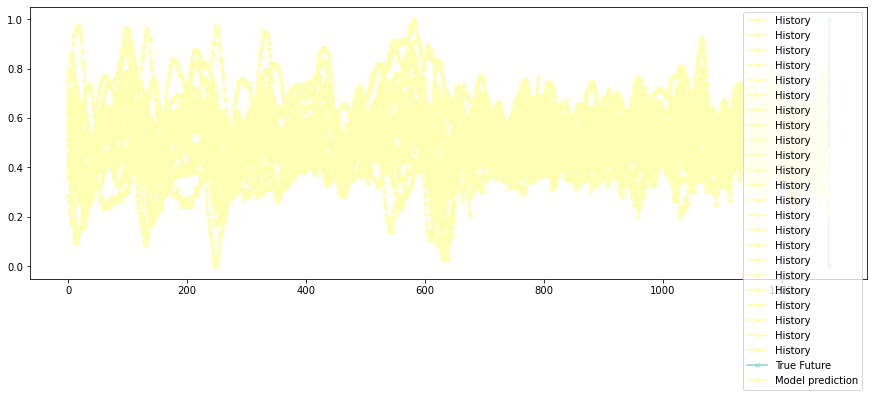

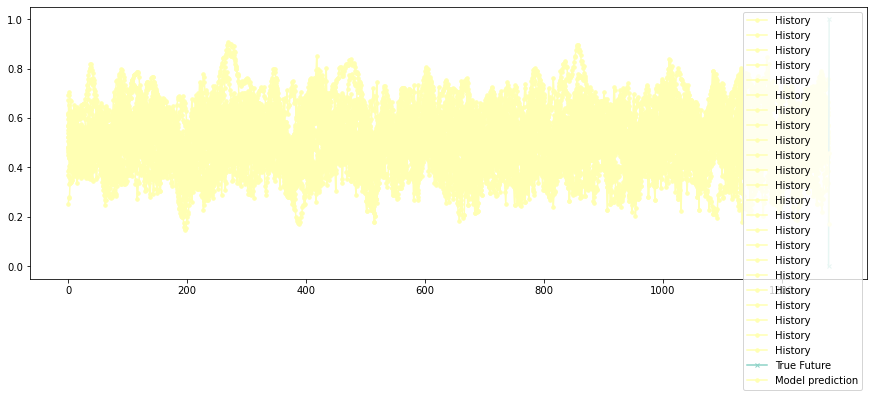

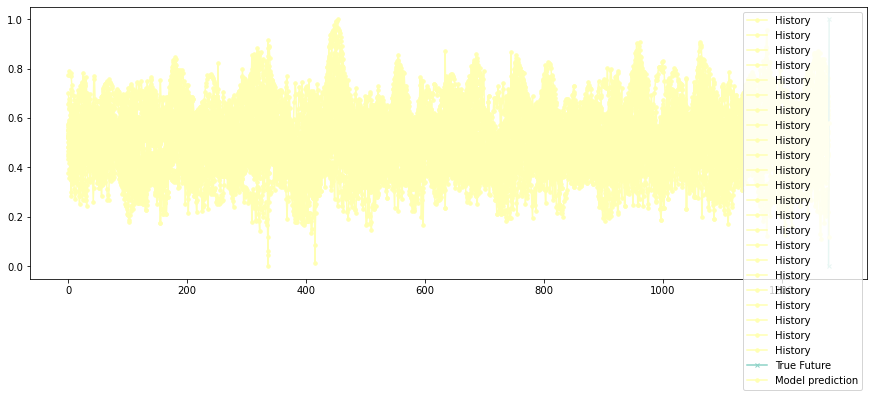

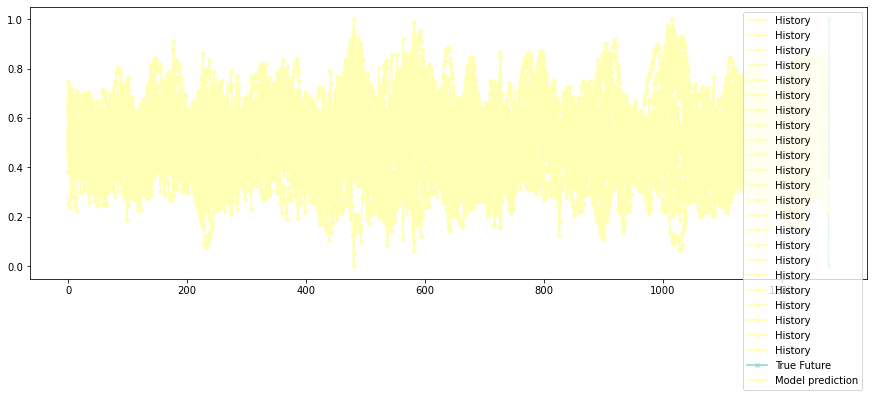

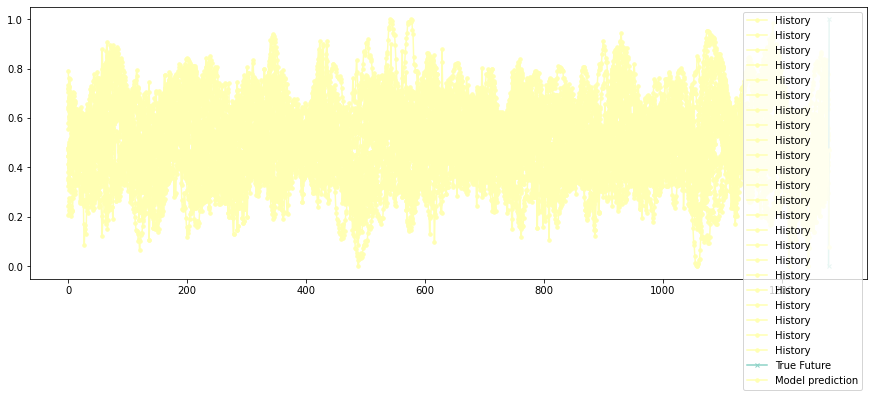

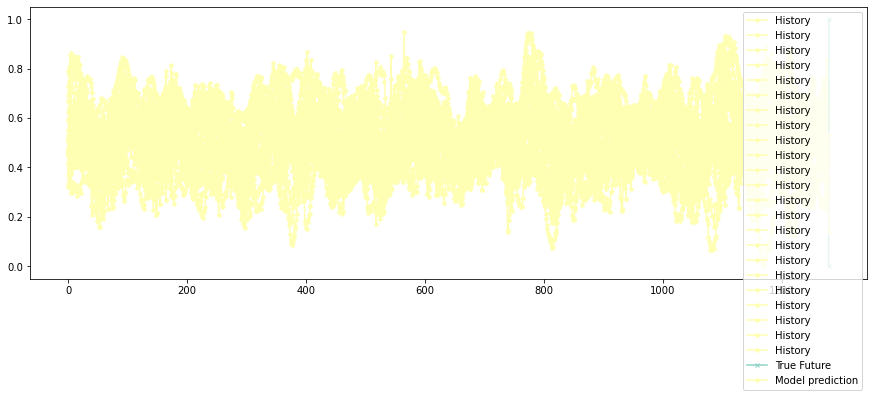

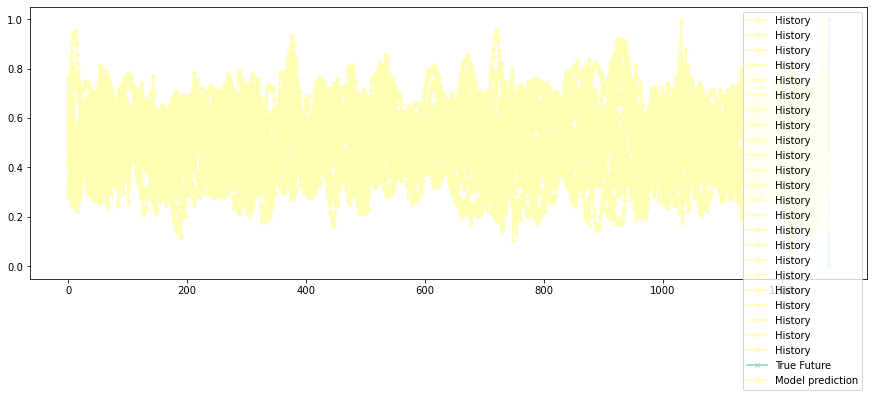

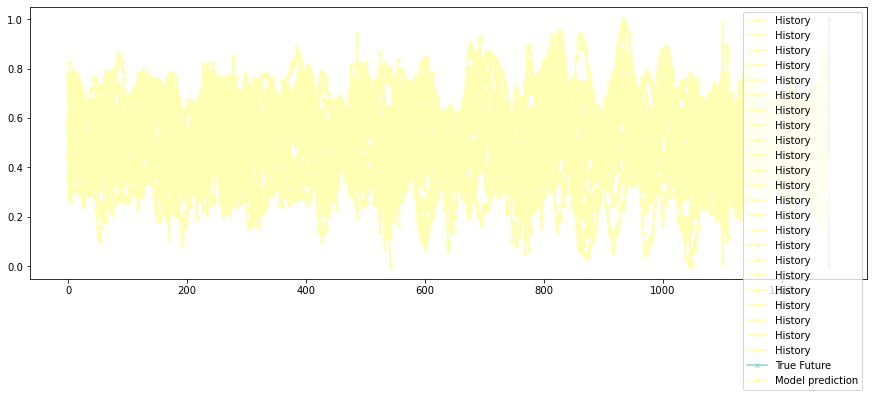

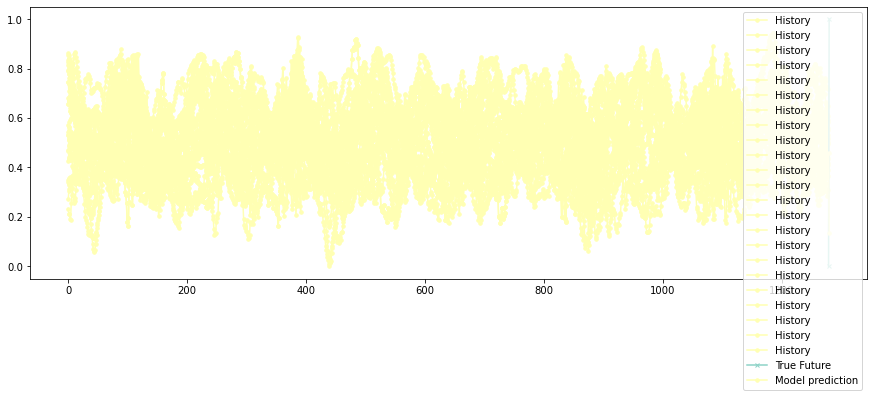

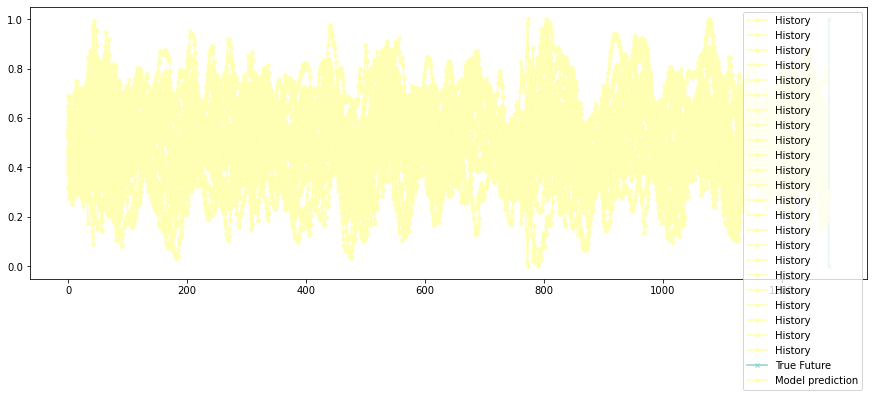

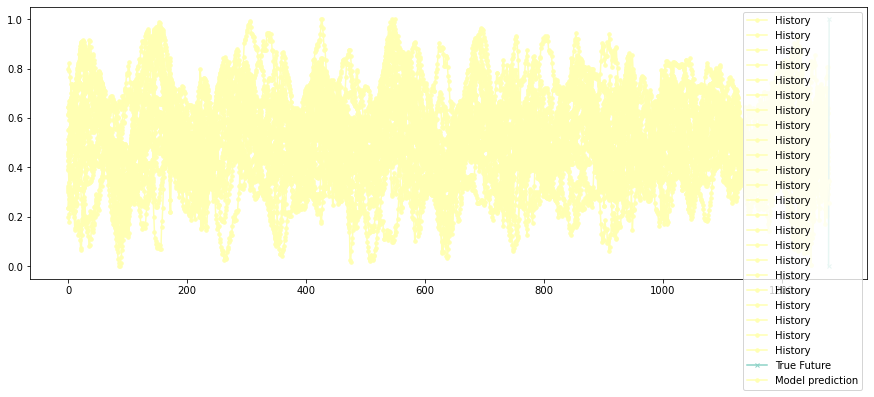

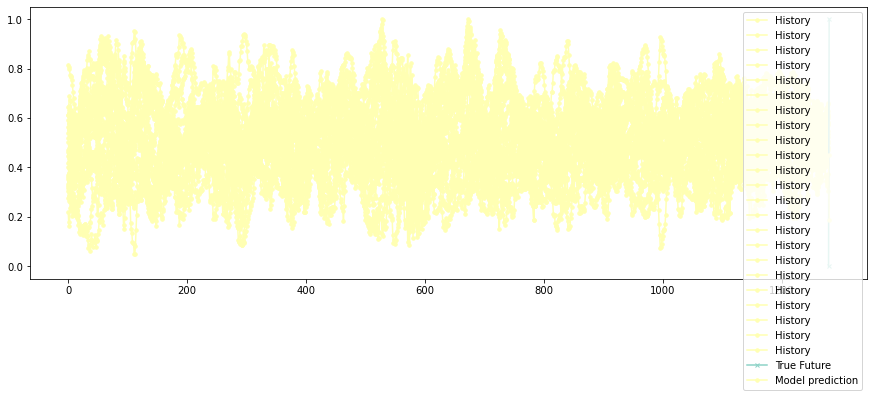

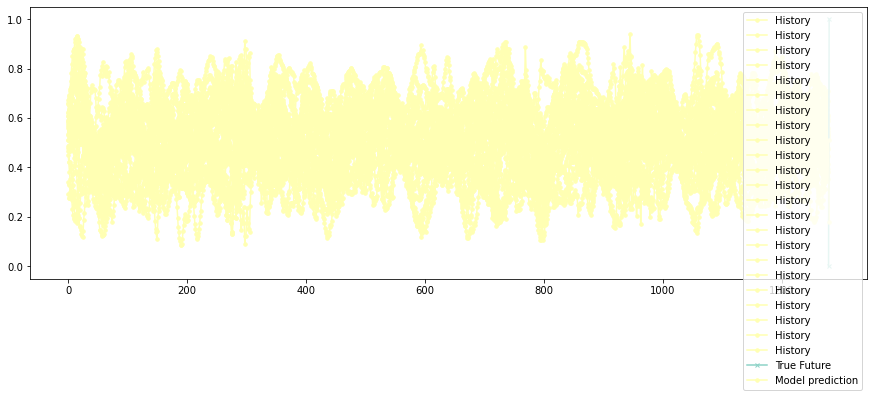

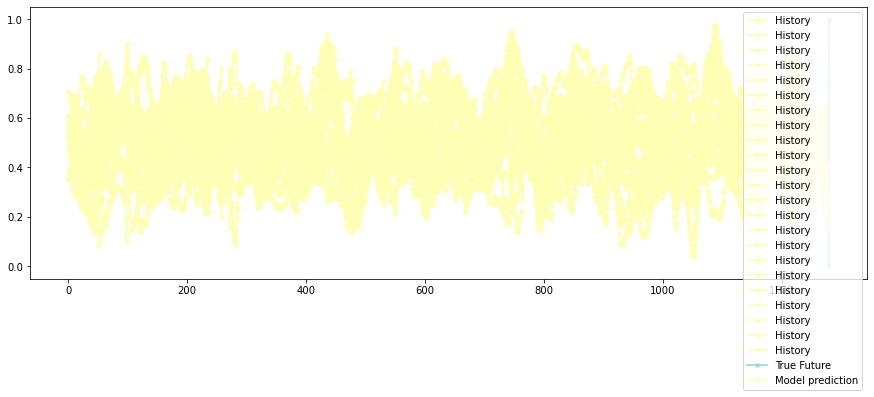

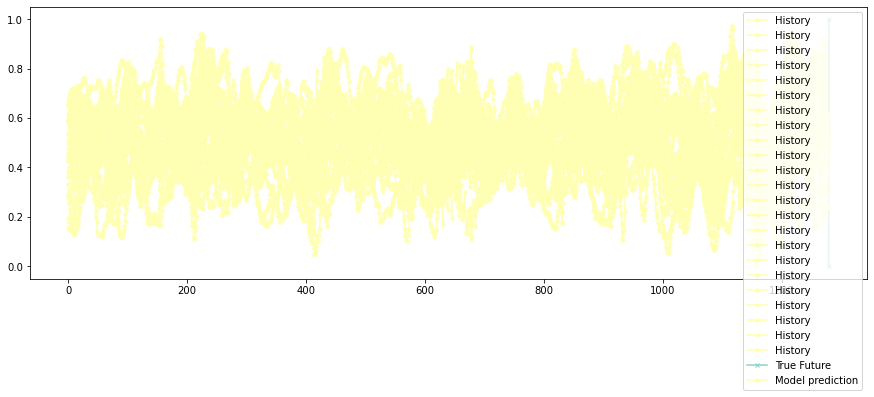

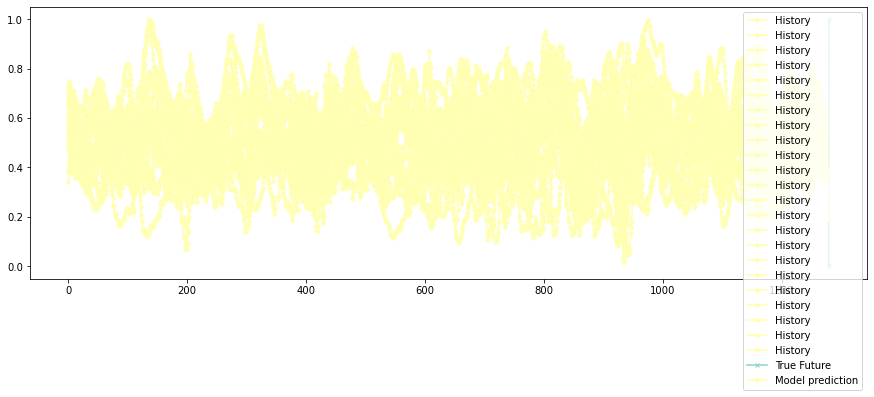

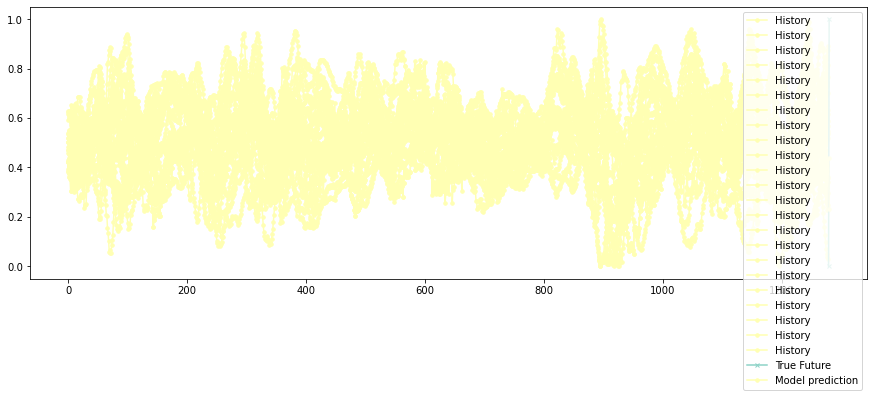

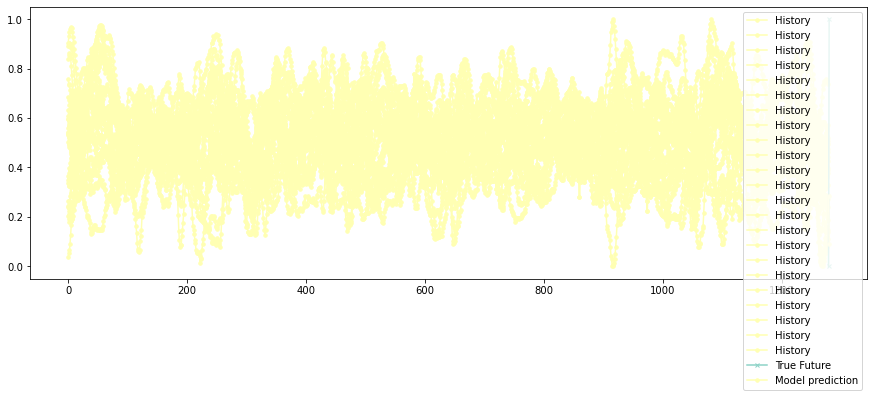

In [55]:
for x, y, y_pred in zip(x_test, y_test, predictions):
  show_plot(x,y,y_pred)

In [57]:
# GRU
inp = Input(shape=x_train.shape[-2:])
x = GRU(128, return_sequences=True)(inp)
x = GRU(64, return_sequences=True)(x)
x = Flatten()(x)
x = Dense(64)(x)
x = Dense(2)(x)
model = keras.Model(inputs=inp, outputs=x)

model.compile(optimizer='adam', loss='mae')
print(model.summary())

history = model.fit(x_train, y_train,
          batch_size=256,
          epochs=5,
          verbose=1,
          validation_data=(x_test, y_test))

plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])

predictions = model.predict(x_test)
mae = mean_absolute_error(y_test, predictions)
results['MAE']['GRU'] = mae
results['Y_PRED']['GRU'] = predictions
print(pd.DataFrame(results)['MAE'])

for x, y, y_pred in zip(x_test, y_test, predictions):
  show_plot(x,y,y_pred)

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1279, 23)]        0         
_________________________________________________________________
gru_2 (GRU)                  (None, 1279, 128)         58752     
_________________________________________________________________
gru_3 (GRU)                  (None, 1279, 64)          37248     
_________________________________________________________________
flatten_1 (Flatten)          (None, 81856)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                5238848   
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 130       
Total params: 5,334,978
Trainable params: 5,334,978
Non-trainable params: 0
____________________________________________

ResourceExhaustedError:    OOM when allocating tensor with shape[1279,135,128] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node gradients/TensorArrayUnstack/TensorListFromTensor_grad/TensorListStack}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[PartitionedCall]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_12430]

Function call stack:
train_function -> train_function -> train_function
